<a href="https://colab.research.google.com/github/Gluquer/proyectoMIADAS_M13/blob/main/M13_Proyect_spring2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

# Inicializar modo offline
init_notebook_mode(connected=True)
cf.go_offline()

# Mostrar archivos en la carpeta actual
print(os.listdir("."))


['.config', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob

archivos = glob.glob("/content/drive/MyDrive/Colab Notebooks/MIADAS 13/*.csv")
for a in archivos:
    print(a)


/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_customers_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_geolocation_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_order_items_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_order_payments_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_order_reviews_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_orders_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_products_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/product_category_name_translation.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/olist_sellers_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/payment_prediction_final_dataset.csv
/content/drive/MyDrive/Colab Notebooks/MIADAS 13/simple_payment_prediction.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from datetime import datetime

# Configurar rutas específicas
base_path = '/content/drive/MyDrive/Colab Notebooks/MIADAS 13/'

# Cargar todos los datasets
customers = pd.read_csv(base_path + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(base_path + 'olist_geolocation_dataset.csv')
order_items = pd.read_csv(base_path + 'olist_order_items_dataset.csv')
order_payments = pd.read_csv(base_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(base_path + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(base_path + 'olist_orders_dataset.csv')
products = pd.read_csv(base_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(base_path + 'olist_sellers_dataset.csv')
category_translation = pd.read_csv(base_path + 'product_category_name_translation.csv')

print("✅ Todos los datasets cargados correctamente")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Todos los datasets cargados correctamente


In [ ]:
# Ver información básica de cada dataset
datasets = {
    'customers': customers,
    'geolocation': geolocation,
    'order_items': order_items,
    'order_payments': order_payments,
    'order_reviews': order_reviews,
    'orders': orders,
    'products': products,
    'sellers': sellers,
    'category_translation': category_translation
}

print("=== INFORMACIÓN DE DATASETS ===")
for name, df in datasets.items():
    print(f"{name:25} {df.shape} | Columnas: {list(df.columns)}")
    print(f"{'':25} Muestra: {df.iloc[0].to_dict() if len(df) > 0 else 'VACIO'}")
    print("-" * 50)

=== INFORMACIÓN DE DATASETS ===
customers                 (99441, 5) | Columnas: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
                          Muestra: {'customer_id': '06b8999e2fba1a1fbc88172c00ba8bc7', 'customer_unique_id': '861eff4711a542e4b93843c6dd7febb0', 'customer_zip_code_prefix': 14409, 'customer_city': 'franca', 'customer_state': 'SP'}
--------------------------------------------------
geolocation               (1000163, 5) | Columnas: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
                          Muestra: {'geolocation_zip_code_prefix': 1037, 'geolocation_lat': -23.54562128115268, 'geolocation_lng': -46.63929204800168, 'geolocation_city': 'sao paulo', 'geolocation_state': 'SP'}
--------------------------------------------------
order_items               (112650, 7) | Columnas: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'ship

In [ ]:
def create_customer_payment_analysis():
    """
    Crea un dataset completo para analizar patrones de pago de clientes
    """
    print("🔗 Construyendo dataset de análisis de clientes y pagos...")

    # PASO 1: Base principal - Orders + Customers
    print("1. Uniendo Orders con Customers...")
    customer_orders = orders.merge(customers, on='customer_id', how='inner')
    print(f"   ✅ Órdenes con info de clientes: {customer_orders.shape}")

    # PASO 2: Agregar información de pagos (DETALLADA para análisis de métodos)
    print("2. Procesando información de pagos...")

    # Primero, análisis detallado de métodos de pago por orden
    payment_methods_analysis = order_payments.groupby('order_id').agg({
        'payment_type': list,  # Todos los métodos usados en la orden
        'payment_sequential': 'max',
        'payment_installments': 'max',
        'payment_value': 'sum'
    }).reset_index()

    payment_methods_analysis['payment_methods_count'] = payment_methods_analysis['payment_type'].apply(len)
    payment_methods_analysis['primary_payment_method'] = payment_methods_analysis['payment_type'].apply(lambda x: x[0] if x else None)
    payment_methods_analysis['has_multiple_payments'] = payment_methods_analysis['payment_methods_count'] > 1

    # Unir con la base principal
    customer_orders_payments = customer_orders.merge(
        payment_methods_analysis,
        on='order_id',
        how='left'
    )
    print(f"   ✅ Con análisis de pagos: {customer_orders_payments.shape}")

    # PASO 3: Agregar información de productos (para saber qué compran)
    print("3. Agregando información de productos...")

    # Enriquecer productos con categorías en inglés
    products_enriched = products.merge(
        category_translation,
        on='product_category_name',
        how='left'
    )

    # Resumen de items por orden
    order_items_summary = order_items.merge(
        products_enriched,
        on='product_id',
        how='left'
    ).groupby('order_id').agg({
        'product_id': 'count',
        'price': 'sum',
        'freight_value': 'sum',
        'product_category_name_english': lambda x: list(x.dropna().unique())
    }).reset_index()

    order_items_summary.columns = [
        'order_id', 'total_items', 'total_items_price',
        'total_freight_value', 'product_categories'
    ]

    customer_orders_payments = customer_orders_payments.merge(
        order_items_summary,
        on='order_id',
        how='left'
    )
    print(f"   ✅ Con información de productos: {customer_orders_payments.shape}")

    # PASO 4: Agregar información de vendedores
    print("4. Agregando información de vendedores...")

    # Resumen de vendedores por orden
    order_sellers = order_items.groupby('order_id').agg({
        'seller_id': 'nunique'
    }).reset_index()
    order_sellers.columns = ['order_id', 'unique_sellers_count']

    customer_orders_payments = customer_orders_payments.merge(
        order_sellers,
        on='order_id',
        how='left'
    )
    print(f"   ✅ Con información de vendedores: {customer_orders_payments.shape}")

    # PASO 5: Calcular métricas por cliente
    print("5. Calculando métricas por cliente...")

    # Primero, crear métricas a nivel de orden
    customer_orders_payments['order_total_value'] = customer_orders_payments['payment_value']
    customer_orders_payments['order_date'] = pd.to_datetime(customer_orders_payments['order_purchase_timestamp'])

    return customer_orders_payments

# Crear el dataset principal
customer_payment_data = create_customer_payment_analysis()

🔗 Construyendo dataset de análisis de clientes y pagos...
1. Uniendo Orders con Customers...
   ✅ Órdenes con info de clientes: (99441, 12)
2. Procesando información de pagos...
   ✅ Con análisis de pagos: (99441, 19)
3. Agregando información de productos...
   ✅ Con información de productos: (99441, 23)
4. Agregando información de vendedores...
   ✅ Con información de vendedores: (99441, 24)
5. Calculando métricas por cliente...


In [ ]:
def create_customer_behavior_dataset(main_dataset):
    """
    Crea un dataset resumen con el comportamiento de pago de cada cliente
    """
    print("📊 Creando dataset de comportamiento de clientes...")

    # Agrupar por cliente único
    customer_behavior = main_dataset.groupby('customer_unique_id').agg({
        # Información demográfica
        'customer_zip_code_prefix': 'first',
        'customer_city': 'first',
        'customer_state': 'first',

        # Comportamiento de órdenes
        'order_id': 'nunique',
        'order_status': lambda x: x.value_counts().to_dict(),
        'order_date': ['min', 'max', 'nunique'],

        # Comportamiento de pagos
        'primary_payment_method': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
        'payment_type': lambda x: list(set([item for sublist in x.dropna() for item in sublist])),
        'has_multiple_payments': 'sum',
        'payment_installments': ['mean', 'max'],
        'payment_value': ['sum', 'mean', 'max'],

        # Comportamiento de productos
        'total_items': 'sum',
        'total_items_price': 'sum',
        'total_freight_value': 'sum',
        'product_categories': lambda x: list(set([item for sublist in x.dropna() for item in sublist]))
    }).reset_index()

    # Aplanar columnas multi-index
    customer_behavior.columns = [
        'customer_unique_id', 'zip_code_prefix', 'city', 'state',
        'total_orders', 'order_status_distribution', 'first_order_date',
        'last_order_date', 'unique_order_dates', 'frequent_payment_method',
        'all_payment_methods_used', 'orders_with_multiple_payments',
        'avg_installments', 'max_installments', 'total_payment_value',
        'avg_order_value', 'max_order_value', 'total_items_purchased',
        'total_items_value', 'total_freight_paid', 'all_categories_purchased'
    ]

    # Calcular métricas adicionales
    customer_behavior['customer_tenure_days'] = (
        pd.to_datetime(customer_behavior['last_order_date']) -
        pd.to_datetime(customer_behavior['first_order_date'])
    ).dt.days

    customer_behavior['avg_items_per_order'] = (
        customer_behavior['total_items_purchased'] / customer_behavior['total_orders']
    )

    customer_behavior['avg_freight_per_order'] = (
        customer_behavior['total_freight_paid'] / customer_behavior['total_orders']
    )

    print(f"   ✅ Dataset de comportamiento: {customer_behavior.shape}")
    return customer_behavior

# Crear dataset de comportamiento
customer_behavior = create_customer_behavior_dataset(customer_payment_data)

📊 Creando dataset de comportamiento de clientes...
   ✅ Dataset de comportamiento: (96096, 24)


In [ ]:
def create_payment_methods_analysis(main_dataset):
    """
    Análisis detallado de métodos de pago por cliente - VERSIÓN CORREGIDA
    """
    print("💳 Creando análisis detallado de métodos de pago...")

    # Expandir la lista de métodos de pago
    payment_expanded = main_dataset.explode('payment_type')

    # Análisis por cliente y método de pago
    payment_analysis = payment_expanded.groupby(['customer_unique_id', 'payment_type']).agg({
        'order_id': 'nunique',
        'payment_value': 'sum',
        'payment_installments': 'mean'
    }).reset_index()

    # Verificar qué métodos de pago existen
    unique_payment_methods = payment_analysis['payment_type'].unique()
    print(f"   Métodos de pago encontrados: {list(unique_payment_methods)}")

    # Crear columnas para cada método de pago de forma más robusta
    payment_methods_list = ['credit_card', 'debit_card', 'voucher', 'boleto']

    # Inicializar DataFrame base
    customer_ids = main_dataset['customer_unique_id'].unique()
    payment_pivot = pd.DataFrame({'customer_unique_id': customer_ids})

    # Para cada método de pago, crear columnas de órdenes y valor
    for method in payment_methods_list:
        # Filtrar datos para este método
        method_data = payment_analysis[payment_analysis['payment_type'] == method]

        # Columnas de órdenes
        orders_col = f'{method}_orders'
        payment_pivot = payment_pivot.merge(
            method_data[['customer_unique_id', 'order_id']].rename(
                columns={'order_id': orders_col}
            ),
            on='customer_unique_id',
            how='left'
        )

        # Columnas de valor
        value_col = f'{method}_value'
        payment_pivot = payment_pivot.merge(
            method_data[['customer_unique_id', 'payment_value']].rename(
                columns={'payment_value': value_col}
            ),
            on='customer_unique_id',
            how='left'
        )

    # Rellenar NaN con 0
    for col in payment_pivot.columns:
        if col != 'customer_unique_id':
            payment_pivot[col] = payment_pivot[col].fillna(0)

    # Calcular preferencias de pago
    order_columns = [f'{method}_orders' for method in payment_methods_list]
    payment_pivot['total_orders_all_methods'] = payment_pivot[order_columns].sum(axis=1)

    # Encontrar método preferido (el con más órdenes)
    def get_preferred_method(row):
        max_orders = 0
        preferred = 'unknown'
        for method in payment_methods_list:
            orders_col = f'{method}_orders'
            if row[orders_col] > max_orders:
                max_orders = row[orders_col]
                preferred = method
        return preferred if max_orders > 0 else 'no_payments'

    payment_pivot['preferred_payment_method'] = payment_pivot.apply(get_preferred_method, axis=1)

    print(f"   ✅ Análisis de pagos: {payment_pivot.shape}")
    return payment_pivot

# Crear análisis de métodos de pago CORREGIDO
payment_analysis = create_payment_methods_analysis(customer_payment_data)

💳 Creando análisis detallado de métodos de pago...
   Métodos de pago encontrados: ['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined']
   ✅ Análisis de pagos: (96096, 11)


In [ ]:
# Combinar todos los datasets
print("🎯 Creando dataset maestro final...")

# Unir comportamiento con análisis de pagos
customer_master_data = customer_behavior.merge(
    payment_analysis,
    on='customer_unique_id',
    how='left'
)

print(f"📊 Dataset maestro final: {customer_master_data.shape}")
print(f"👥 Clientes únicos analizados: {len(customer_master_data)}")

# Mostrar estructura del dataset
print("\n🎯 ESTRUCTURA DEL DATASET MAESTRO:")
print(customer_master_data.info())

🎯 Creando dataset maestro final...
📊 Dataset maestro final: (96096, 34)
👥 Clientes únicos analizados: 96096

🎯 ESTRUCTURA DEL DATASET MAESTRO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             96096 non-null  object        
 1   zip_code_prefix                96096 non-null  int64         
 2   city                           96096 non-null  object        
 3   state                          96096 non-null  object        
 4   total_orders                   96096 non-null  int64         
 5   order_status_distribution      96096 non-null  object        
 6   first_order_date               96096 non-null  datetime64[ns]
 7   last_order_date                96096 non-null  datetime64[ns]
 8   unique_order_dates             96096 non-null  int64         
 9   freque

In [ ]:
# 🎯 FEATURES ESENCIALES (las que YA existen en tu dataset)
essential_features = [
    'customer_unique_id',           # Solo para identificar
    'preferred_payment_method',     # TARGET - lo que queremos predecir

    # FEATURES MÁS IMPORTANTES (que YA tienes):
    'state',                        # Dónde vive
    'total_orders',                 # Cuánto compra
    'total_payment_value',          # Cuánto gasta
    'avg_order_value',              # Tipo de comprador
    'customer_tenure_days',         # Tiempo como cliente

    # HISTORIAL DE PAGOS (CRÍTICAS):
    'credit_card_orders',           # Veces que usó crédito
    'boleto_orders',                # Veces que usó boleto
    'voucher_orders',               # Veces que usó voucher
    'debit_card_orders',            # Veces que usó débito
    'avg_installments',             # Si le gustan las cuotas
]

# Crear dataset con las features que YA existen
simple_payment_df = customer_master_data[essential_features].copy()

print(f"✅ Dataset base creado: {simple_payment_df.shape}")

# 🔧 AHORA SÍ crear las 3 features derivadas:
print("🔧 Creando features derivadas...")

# 1. Frecuencia de pagos
simple_payment_df['payment_frequency'] = (
    simple_payment_df['total_orders'] /
    simple_payment_df['customer_tenure_days'].replace(0, 1)
)

# 2. Proporción de uso de tarjeta de crédito
simple_payment_df['credit_card_ratio'] = (
    simple_payment_df['credit_card_orders'] /
    simple_payment_df['total_orders'].replace(0, 1)
)

# 3. Cliente premium (top 25% en valor de orden)
premium_threshold = simple_payment_df['avg_order_value'].quantile(0.75)
simple_payment_df['premium_customer'] = (
    simple_payment_df['avg_order_value'] > premium_threshold
).astype(int)

# 🧹 Limpiar valores nulos rápidamente
simple_payment_df = simple_payment_df.fillna({
    'avg_installments': simple_payment_df['avg_installments'].median(),
    'avg_order_value': simple_payment_df['avg_order_value'].median()
})

# 📊 RESULTADO FINAL
print(f"\n🎯 DATASET FINAL LISTO:")
print(f"   Clientes: {len(simple_payment_df)}")
print(f"   Features: {len(simple_payment_df.columns)}")
print(f"   Target: preferred_payment_method")

print(f"\n📋 COLUMNAS FINALES:")
for i, col in enumerate(simple_payment_df.columns, 1):
    print(f"   {i:2d}. {col}")

# 💾 GUARDAR EN EXCEL
print("\n💾 Exportando a Excel...")
output_excel_path = base_path + 'payment_prediction_dataset.xlsx'

with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    # Hoja principal con todos los datos
    simple_payment_df.to_excel(writer, sheet_name='Prediccion_Pagos', index=False)

    # Hoja con descripción de features
    features_description = pd.DataFrame({
        'Feature': simple_payment_df.columns,
        'Tipo': simple_payment_df.dtypes.astype(str),
        'Descripción': [
            'ID único del cliente',
            'MÉTODO A PREDECIR: credit_card, boleto, voucher, debit_card',
            'Estado donde vive el cliente',
            'Total de órdenes realizadas',
            'Valor total gastado por el cliente',
            'Valor promedio por orden',
            'Días desde la primera compra',
            'Número de órdenes pagadas con tarjeta de crédito',
            'Número de órdenes pagadas con boleto',
            'Número de órdenes pagadas con voucher',
            'Número de órdenes pagadas con tarjeta de débito',
            'Promedio de cuotas usadas en pagos',
            'Frecuencia de compras (órdenes/día)',
            'Proporción de uso de tarjeta de crédito',
            'Cliente premium (1) o estándar (0)'
        ]
    })
    features_description.to_excel(writer, sheet_name='Descripcion_Features', index=False)

    # Hoja con distribución del target
    target_distribution = simple_payment_df['preferred_payment_method'].value_counts().reset_index()
    target_distribution.columns = ['Metodo_Pago', 'Cantidad_Clientes']
    target_distribution['Porcentaje'] = (target_distribution['Cantidad_Clientes'] / len(simple_payment_df)) * 100
    target_distribution.to_excel(writer, sheet_name='Distribucion_Target', index=False)

print(f"✅ EXCEL GUARDADO: {output_excel_path}")

# 🔍 Mostrar resumen
print(f"\n📊 RESUMEN DEL ARCHIVO EXCEL:")
print(f"   📁 Archivo: payment_prediction_dataset.xlsx")
print(f"   📊 Hojas:")
print(f"     1. Prediccion_Pagos - Dataset completo ({len(simple_payment_df)} filas, {len(simple_payment_df.columns)} columnas)")
print(f"     2. Descripcion_Features - Explicación de cada columna")
print(f"     3. Distribucion_Target - Distribución de métodos de pago")

print(f"\n🔍 MUESTRA DE DATOS:")
print(simple_payment_df.head(3))

✅ Dataset base creado: (96096, 12)
🔧 Creando features derivadas...

🎯 DATASET FINAL LISTO:
   Clientes: 96096
   Features: 15
   Target: preferred_payment_method

📋 COLUMNAS FINALES:
    1. customer_unique_id
    2. preferred_payment_method
    3. state
    4. total_orders
    5. total_payment_value
    6. avg_order_value
    7. customer_tenure_days
    8. credit_card_orders
    9. boleto_orders
   10. voucher_orders
   11. debit_card_orders
   12. avg_installments
   13. payment_frequency
   14. credit_card_ratio
   15. premium_customer

💾 Exportando a Excel...
✅ EXCEL GUARDADO: /content/drive/MyDrive/Colab Notebooks/MIADAS 13/payment_prediction_dataset.xlsx

📊 RESUMEN DEL ARCHIVO EXCEL:
   📁 Archivo: payment_prediction_dataset.xlsx
   📊 Hojas:
     1. Prediccion_Pagos - Dataset completo (96096 filas, 15 columnas)
     2. Descripcion_Features - Explicación de cada columna
     3. Distribucion_Target - Distribución de métodos de pago

🔍 MUESTRA DE DATOS:
                 customer_uniqu

In [ ]:
simple_payment_df

,customer_unique_id,preferred_payment_method,state,total_orders,total_payment_value,avg_order_value,customer_tenure_days,credit_card_orders,boleto_orders,voucher_orders,debit_card_orders,avg_installments,payment_frequency,credit_card_ratio,premium_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card,SP,1,141.90,141.90,0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,SP,1,27.19,27.19,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
2,0000f46a3911fa3c0805444483337064,credit_card,SC,1,86.22,86.22,0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card,PA,1,43.62,43.62,0,1.0,0.0,0.0,0.0,4.0,1.0,1.0,0
4,0004aac84e0df4da2b147fca70cf8255,credit_card,SP,1,196.89,196.89,0,1.0,0.0,0.0,0.0,6.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,credit_card,PE,1,2067.42,2067.42,0,1.0,0.0,0.0,0.0,10.0,1.0,1.0,1
96092,fffea47cd6d3cc0a88bd621562a9d061,credit_card,BA,1,84.58,84.58,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
96093,ffff371b4d645b6ecea244b27531430a,credit_card,MT,1,112.46,112.46,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0
96094,ffff5962728ec6157033ef9805bacc48,credit_card,ES,1,133.69,133.69,0,1.0,0.0,0.0,0.0,5.0,1.0,1.0,0


In [ ]:
# Exportar a Excel
output_file = base_path + 'customer_payment_analysis_complete.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Dataset maestro completo
    customer_master_data.to_excel(writer, sheet_name='Customer_Payment_Analysis', index=False)

    # Dataset detallado de órdenes
    customer_payment_data.to_excel(writer, sheet_name='Detailed_Order_Data', index=False)

    # Resumen de métodos de pago
    payment_summary = customer_master_data['preferred_payment_method'].value_counts().reset_index()
    payment_summary.columns = ['payment_method', 'customer_count']
    payment_summary.to_excel(writer, sheet_name='Payment_Method_Summary', index=False)

    # Métricas por estado
    state_analysis = customer_master_data.groupby('state').agg({
        'customer_unique_id': 'count',
        'total_orders': 'sum',
        'total_payment_value': 'sum',
        'preferred_payment_method': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
    }).reset_index()
    state_analysis.to_excel(writer, sheet_name='State_Analysis', index=False)

print(f"✅ Exportación completada: {output_file}")

✅ Exportación completada: /content/drive/MyDrive/Colab Notebooks/MIADAS 13/customer_payment_analysis_complete.xlsx


In [ ]:
print("=== ANÁLISIS RÁPIDO DE MÉTODOS DE PAGO ===")

# Métodos de pago más populares
preferred_methods = customer_master_data['preferred_payment_method'].value_counts()
print("\n🏆 MÉTODOS DE PAGO PREFERIDOS:")
for method, count in preferred_methods.items():
    percentage = (count / len(customer_master_data)) * 100
    print(f"   {method}: {count} clientes ({percentage:.1f}%)")

# Valor por método de pago
print("\n💰 VALOR TOTAL POR MÉTODO DE PAGO:")
if 'credit_card_value' in customer_master_data.columns:
    total_credit = customer_master_data['credit_card_value'].sum()
    total_debit = customer_master_data['debit_card_value'].sum()
    total_voucher = customer_master_data['voucher_value'].sum()
    total_boleto = customer_master_data['boleto_value'].sum()

    print(f"   💳 Credit Card: R$ {total_credit:,.2f}")
    print(f"   💳 Debit Card: R$ {total_debit:,.2f}")
    print(f"   🎫 Voucher: R$ {total_voucher:,.2f}")
    print(f"   📄 Boleto: R$ {total_boleto:,.2f}")

# Clientes por estado
print("\n📍 TOP 5 ESTADOS CON MÁS CLIENTES:")
top_states = customer_master_data['state'].value_counts().head(5)
for state, count in top_states.items():
    print(f"   {state}: {count} clientes")

=== ANÁLISIS RÁPIDO DE MÉTODOS DE PAGO ===

🏆 MÉTODOS DE PAGO PREFERIDOS:
   credit_card: 74064 clientes (77.1%)
   boleto: 19041 clientes (19.8%)
   voucher: 1504 clientes (1.6%)
   debit_card: 1484 clientes (1.5%)
   no_payments: 3 clientes (0.0%)

💰 VALOR TOTAL POR MÉTODO DE PAGO:
   💳 Credit Card: R$ 12,838,203.11
   💳 Debit Card: R$ 218,138.81
   🎫 Voucher: R$ 816,063.71
   📄 Boleto: R$ 2,869,361.27

📍 TOP 5 ESTADOS CON MÁS CLIENTES:
   SP: 40296 clientes
   RJ: 12379 clientes
   MG: 11254 clientes
   RS: 5276 clientes
   PR: 4881 clientes


In [ ]:
# Cargar el dataset completo
print("📊 CARGANDO DATASET PARA EDA...")
df = customer_master_data.copy()
print(f"Dataset shape: {df.shape}")

# 2.1 Análisis de Estructura y Calidad de Datos
print("\n" + "="*50)
print("2.1 ANÁLISIS DE ESTRUCTURA Y CALIDAD DE DATOS")
print("="*50)

# Información general
print("📋 INFORMACIÓN GENERAL:")
print(f"• Total de clientes: {len(df):,}")
print(f"• Total de columnas: {len(df.columns)}")
print(f"• Período analizado: {df['first_order_date'].min()} a {df['last_order_date'].max()}")

# Tipos de datos y valores nulos
print("\n🔍 CALIDAD DE DATOS:")
print(df.info())

# Valores nulos por columna
null_analysis = df.isnull().sum()
null_percentage = (null_analysis / len(df)) * 100
null_summary = pd.DataFrame({
    'Valores_Nulos': null_analysis,
    'Porcentaje_Nulos': null_percentage
})
print("\n📊 RESUMEN DE VALORES NULOS:")
print(null_summary[null_summary['Valores_Nulos'] > 0])

📊 CARGANDO DATASET PARA EDA...
Dataset shape: (96096, 34)

2.1 ANÁLISIS DE ESTRUCTURA Y CALIDAD DE DATOS
📋 INFORMACIÓN GENERAL:
• Total de clientes: 96,096
• Total de columnas: 34
• Período analizado: 2016-09-04 21:15:19 a 2018-10-17 17:30:18

🔍 CALIDAD DE DATOS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             96096 non-null  object        
 1   zip_code_prefix                96096 non-null  int64         
 2   city                           96096 non-null  object        
 3   state                          96096 non-null  object        
 4   total_orders                   96096 non-null  int64         
 5   order_status_distribution      96096 non-null  object        
 6   first_order_date               96096 non-null  datetime64[ns]
 7   last_order_date    

In [ ]:
# =============================================================================
# SPRINT 1 - DEFINICIÓN DEL PROBLEMA Y EDA INICIAL
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🚀 INICIANDO SPRINT 1 - EDA Y DEFINICIÓN DEL PROBLEMA")
print("=" * 70)

🚀 INICIANDO SPRINT 1 - EDA Y DEFINICIÓN DEL PROBLEMA


In [ ]:
# PROBLEMA DE NEGOCIO PRINCIPAL
problema_negocio = """
PROBLEMA DE NEGOCIO:
"Optimización de la Experiencia del Cliente mediante el Análisis de Patrones de Pago y Comportamiento de Compra"

OBJETIVOS ESTRATÉGICOS:
1. PREDICCIÓN DE CLIENTES DE ALTO VALOR: Identificar clientes con mayor potencial de gasto
2. PERSONALIZACIÓN DE MÉTODOS DE PAGO: Ofrecer métodos de pago preferidos por segmento
3. REDUCCIÓN DE ABANDONO: Predecir clientes en riesgo de churn
4. OPTIMIZACIÓN DE INGRESOS: Maximizar valor de vida del cliente (LTV)

ALCANCE MVP:
- Segmentación de clientes por comportamiento de pago
- Identificación de factores que influyen en el valor del cliente
- Métricas base para seguimiento mensual
"""
print(problema_negocio)


PROBLEMA DE NEGOCIO: 
"Optimización de la Experiencia del Cliente mediante el Análisis de Patrones de Pago y Comportamiento de Compra"

OBJETIVOS ESTRATÉGICOS:
1. PREDICCIÓN DE CLIENTES DE ALTO VALOR: Identificar clientes con mayor potencial de gasto
2. PERSONALIZACIÓN DE MÉTODOS DE PAGO: Ofrecer métodos de pago preferidos por segmento
3. REDUCCIÓN DE ABANDONO: Predecir clientes en riesgo de churn
4. OPTIMIZACIÓN DE INGRESOS: Maximizar valor de vida del cliente (LTV)

ALCANCE MVP:
- Segmentación de clientes por comportamiento de pago
- Identificación de factores que influyen en el valor del cliente
- Métricas base para seguimiento mensual



In [ ]:
# HIPÓTESIS A VALIDAR
hipotesis = """
HIPÓTESIS PRINCIPALES:

H1: Los clientes con mayor valor de compra prefieren tarjeta de crédito
H2: Los clientes de ciertos estados geográficos tienen preferencias de pago específicas
H3: El número de órdenes influye en la preferencia del método de pago
"""
print(hipotesis)


HIPÓTESIS PRINCIPALES:

H1: Los clientes con mayor valor de compra prefieren tarjeta de crédito
H2: Los clientes de ciertos estados geográficos tienen preferencias de pago específicas
H3: El número de órdenes influye en la preferencia del método de pago



In [ ]:
# Cargar el dataset completo
print("📊 CARGANDO DATASET PARA EDA...")
df = customer_master_data.copy()
print(f"Dataset shape: {df.shape}")

# 2.1 Análisis de Estructura y Calidad de Datos
print("\n" + "="*50)
print("2.1 ANÁLISIS DE ESTRUCTURA Y CALIDAD DE DATOS")
print("="*50)

# Información general
print("📋 INFORMACIÓN GENERAL:")
print(f"• Total de clientes: {len(df):,}")
print(f"• Total de columnas: {len(df.columns)}")
print(f"• Período analizado: {df['first_order_date'].min()} a {df['last_order_date'].max()}")

# Tipos de datos y valores nulos
print("\n🔍 CALIDAD DE DATOS:")
print(df.info())

# Valores nulos por columna
null_analysis = df.isnull().sum()
null_percentage = (null_analysis / len(df)) * 100
null_summary = pd.DataFrame({
    'Valores_Nulos': null_analysis,
    'Porcentaje_Nulos': null_percentage
})
print("\n📊 RESUMEN DE VALORES NULOS:")
print(null_summary[null_summary['Valores_Nulos'] > 0])

📊 CARGANDO DATASET PARA EDA...
Dataset shape: (96096, 34)

2.1 ANÁLISIS DE ESTRUCTURA Y CALIDAD DE DATOS
📋 INFORMACIÓN GENERAL:
• Total de clientes: 96,096
• Total de columnas: 34
• Período analizado: 2016-09-04 21:15:19 a 2018-10-17 17:30:18

🔍 CALIDAD DE DATOS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             96096 non-null  object        
 1   zip_code_prefix                96096 non-null  int64         
 2   city                           96096 non-null  object        
 3   state                          96096 non-null  object        
 4   total_orders                   96096 non-null  int64         
 5   order_status_distribution      96096 non-null  object        
 6   first_order_date               96096 non-null  datetime64[ns]
 7   last_order_date    


2.2 ANÁLISIS DEMOGRÁFICO


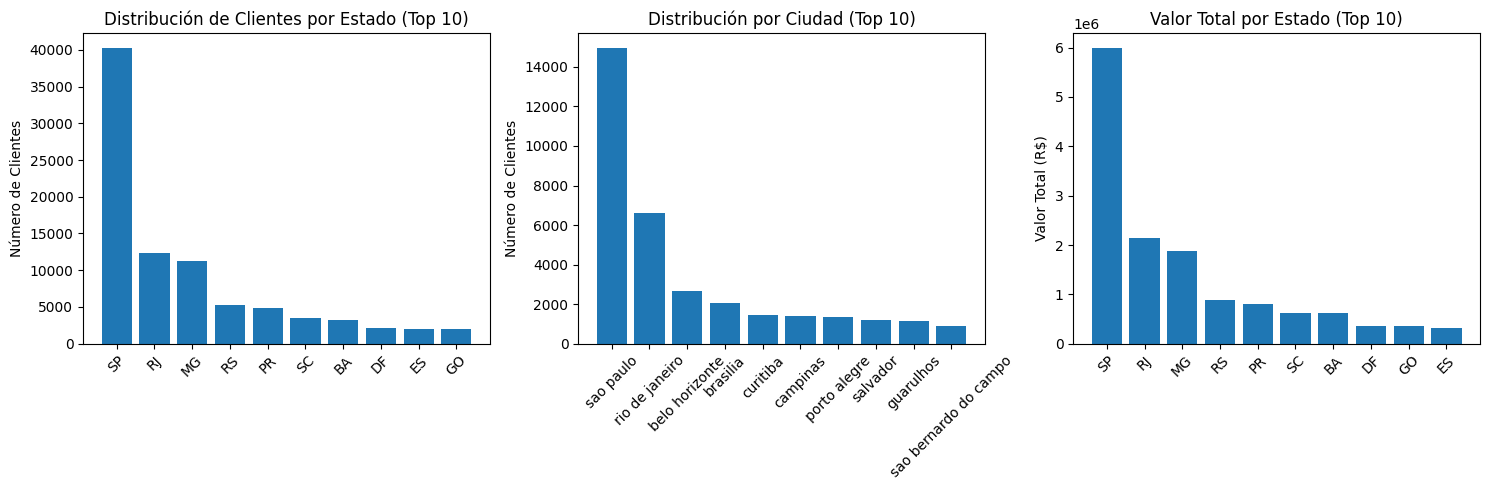

📍 RESUMEN GEOGRÁFICO:
• Estados con más clientes: ['SP', 'RJ', 'MG']
• Ciudades con más clientes: ['sao paulo', 'rio de janeiro', 'belo horizonte']
• Estados con mayor valor: ['SP', 'RJ', 'MG']


In [ ]:
# 2.2 ANÁLISIS DEMOGRÁFICO
print("\n" + "="*50)
print("2.2 ANÁLISIS DEMOGRÁFICO")
print("="*50)

# Distribución por estado
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
state_dist = df['state'].value_counts().head(10)
plt.bar(state_dist.index, state_dist.values)
plt.title('Distribución de Clientes por Estado (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Número de Clientes')

plt.subplot(1, 3, 2)
city_dist = df['city'].value_counts().head(10)
plt.bar(city_dist.index, city_dist.values)
plt.title('Distribución por Ciudad (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Número de Clientes')

plt.subplot(1, 3, 3)
top_states_value = df.groupby('state')['total_payment_value'].sum().sort_values(ascending=False).head(10)
plt.bar(top_states_value.index, top_states_value.values)
plt.title('Valor Total por Estado (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Valor Total (R$)')

plt.tight_layout()
plt.show()

print("📍 RESUMEN GEOGRÁFICO:")
print(f"• Estados con más clientes: {state_dist.index.tolist()[:3]}")
print(f"• Ciudades con más clientes: {city_dist.index.tolist()[:3]}")
print(f"• Estados con mayor valor: {top_states_value.index.tolist()[:3]}")


2.3 ANÁLISIS DE MÉTODOS DE PAGO


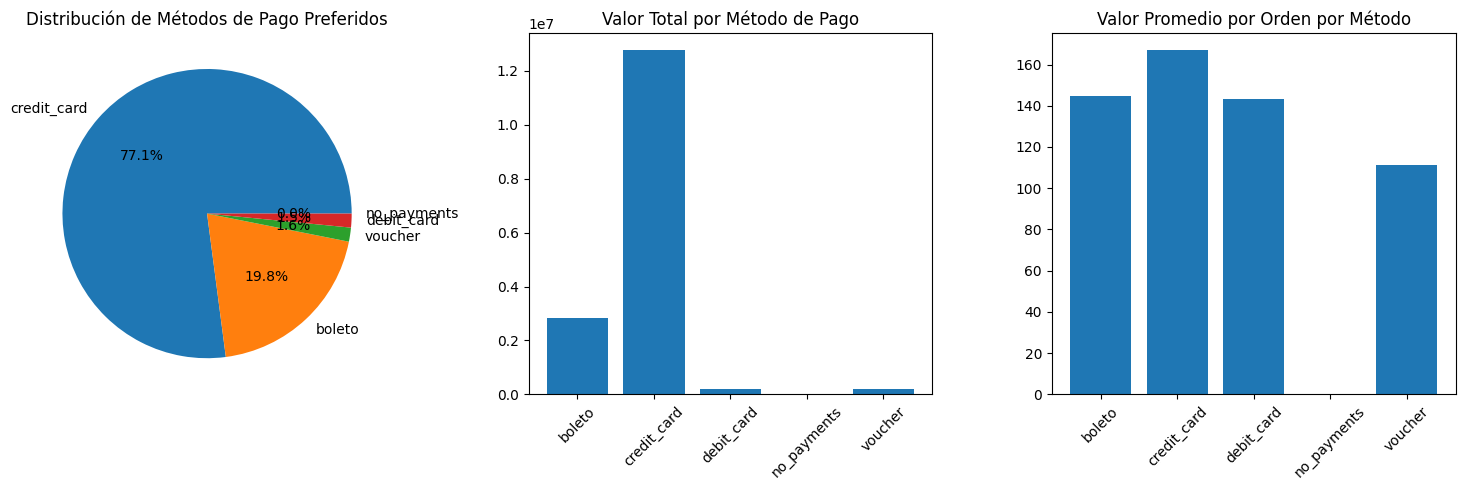

💳 RESUMEN MÉTODOS DE PAGO:
• credit_card: 74064 clientes (77.1%) - Avg Order: R$ 167.03
• boleto: 19041 clientes (19.8%) - Avg Order: R$ 144.92
• voucher: 1504 clientes (1.6%) - Avg Order: R$ 111.47
• debit_card: 1484 clientes (1.5%) - Avg Order: R$ 143.04
• no_payments: 3 clientes (0.0%) - Avg Order: R$ 0.00


In [ ]:
# 2.3 ANÁLISIS DE MÉTODOS DE PAGO
print("\n" + "="*50)
print("2.3 ANÁLISIS DE MÉTODOS DE PAGO")
print("="*50)

# Distribución de métodos de pago preferidos
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
payment_dist = df['preferred_payment_method'].value_counts()
plt.pie(payment_dist.values, labels=payment_dist.index, autopct='%1.1f%%')
plt.title('Distribución de Métodos de Pago Preferidos')

plt.subplot(1, 3, 2)
# Valor total por método de pago
payment_value = df.groupby('preferred_payment_method')['total_payment_value'].sum()
plt.bar(payment_value.index, payment_value.values)
plt.title('Valor Total por Método de Pago')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Orden promedio por método de pago
avg_order_by_payment = df.groupby('preferred_payment_method')['avg_order_value'].mean()
plt.bar(avg_order_by_payment.index, avg_order_by_payment.values)
plt.title('Valor Promedio por Orden por Método')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("💳 RESUMEN MÉTODOS DE PAGO:")
for method in payment_dist.index:
    clients = payment_dist[method]
    percentage = (clients / len(df)) * 100
    avg_value = avg_order_by_payment[method]
    print(f"• {method}: {clients} clientes ({percentage:.1f}%) - Avg Order: R$ {avg_value:.2f}")


2.4 ANÁLISIS DE COMPORTAMIENTO DE COMPRA


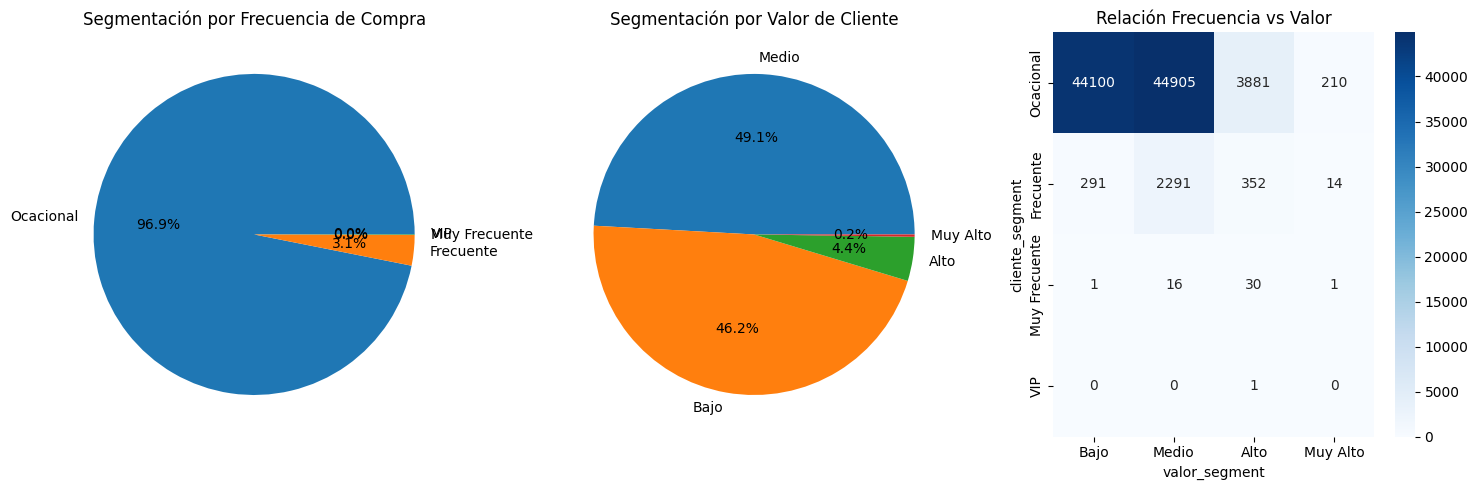

📈 RESUMEN SEGMENTACIÓN:
• Clientes ocasionales (1 orden): 93099 (96.9%)
• Clientes frecuentes (2-3 órdenes): 2948 (3.1%)
• Clientes VIP (+10 órdenes): 1 (0.0%)


In [ ]:
# 2.4 ANÁLISIS DE COMPORTAMIENTO DE COMPRA
print("\n" + "="*50)
print("2.4 ANÁLISIS DE COMPORTAMIENTO DE COMPRA")
print("="*50)

# Crear segmentos de clientes
df['cliente_segment'] = pd.cut(df['total_orders'],
                              bins=[0, 1, 3, 10, 100],
                              labels=['Ocacional', 'Frecuente', 'Muy Frecuente', 'VIP'])

df['valor_segment'] = pd.cut(df['total_payment_value'],
                            bins=[0, 100, 500, 2000, df['total_payment_value'].max()],
                            labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
segment_dist = df['cliente_segment'].value_counts()
plt.pie(segment_dist.values, labels=segment_dist.index, autopct='%1.1f%%')
plt.title('Segmentación por Frecuencia de Compra')

plt.subplot(1, 3, 2)
valor_dist = df['valor_segment'].value_counts()
plt.pie(valor_dist.values, labels=valor_dist.index, autopct='%1.1f%%')
plt.title('Segmentación por Valor de Cliente')

plt.subplot(1, 3, 3)
# Relación entre frecuencia y valor
cross_segment = pd.crosstab(df['cliente_segment'], df['valor_segment'])
sns.heatmap(cross_segment, annot=True, fmt='d', cmap='Blues')
plt.title('Relación Frecuencia vs Valor')

plt.tight_layout()
plt.show()

print("📈 RESUMEN SEGMENTACIÓN:")
print(f"• Clientes ocasionales (1 orden): {segment_dist['Ocacional']} ({segment_dist['Ocacional']/len(df)*100:.1f}%)")
print(f"• Clientes frecuentes (2-3 órdenes): {segment_dist['Frecuente']} ({segment_dist['Frecuente']/len(df)*100:.1f}%)")
print(f"• Clientes VIP (+10 órdenes): {segment_dist['VIP']} ({segment_dist['VIP']/len(df)*100:.1f}%)")


2.5 ANÁLISIS DE CORRELACIONES


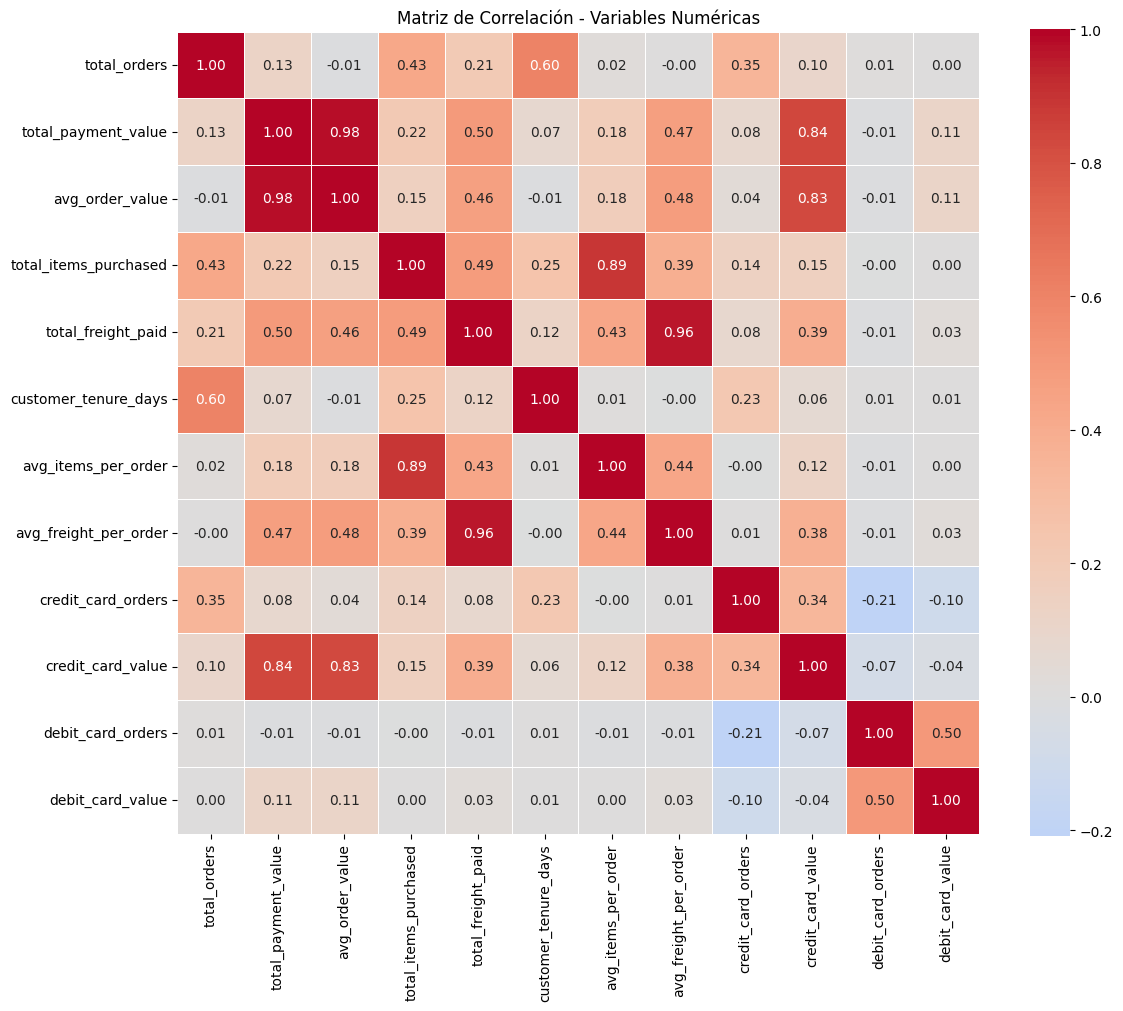

🔗 CORRELACIONES DESTACADAS:
• total_payment_value vs avg_order_value: 0.978
• avg_order_value vs total_payment_value: 0.978
• avg_freight_per_order vs total_freight_paid: 0.964
• total_freight_paid vs avg_freight_per_order: 0.964
• avg_items_per_order vs total_items_purchased: 0.892
• total_items_purchased vs avg_items_per_order: 0.892
• credit_card_value vs total_payment_value: 0.840
• total_payment_value vs credit_card_value: 0.840
• avg_order_value vs credit_card_value: 0.829
• credit_card_value vs avg_order_value: 0.829


In [ ]:
# 2.5 ANÁLISIS DE CORRELACIONES
print("\n" + "="*50)
print("2.5 ANÁLISIS DE CORRELACIONES")
print("="*50)

# Seleccionar variables numéricas para correlación
numeric_columns = [
    'total_orders', 'total_payment_value', 'avg_order_value',
    'total_items_purchased', 'total_freight_paid', 'customer_tenure_days',
    'avg_items_per_order', 'avg_freight_per_order', 'credit_card_orders',
    'credit_card_value', 'debit_card_orders', 'debit_card_value'
]

# Filtrar columnas existentes
numeric_columns = [col for col in numeric_columns if col in df.columns]

correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

print("🔗 CORRELACIONES DESTACADAS:")
high_corr = correlation_matrix.unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 0.99]  # Excluir autocorrelaciones
for idx, value in high_corr.head(10).items():
    if abs(value) > 0.5:
        print(f"• {idx[0]} vs {idx[1]}: {value:.3f}")

array([<Axes: title={'center': 'total_orders'}, xlabel='preferred_payment_method'>,
       <Axes: title={'center': 'avg_order_value'}, xlabel='preferred_payment_method'>,
       <Axes: title={'center': 'total_payment_value'}, xlabel='preferred_payment_method'>,
       <Axes: title={'center': 'customer_tenure_days'}, xlabel='preferred_payment_method'>],
      dtype=object)

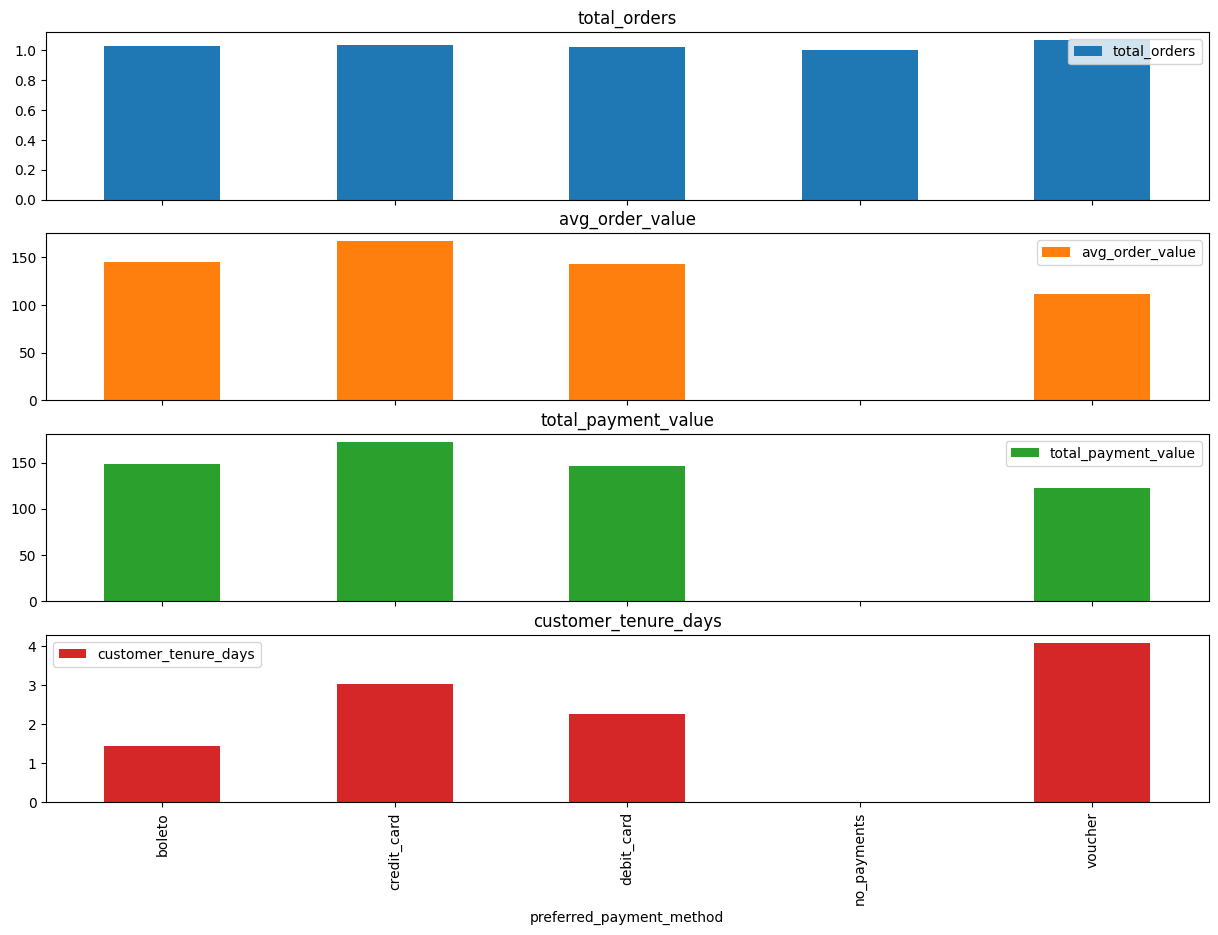

In [ ]:
# Comparar métricas de comportamiento por método de pago
behavior_by_payment = df.groupby('preferred_payment_method')[
    ['total_orders', 'avg_order_value', 'total_payment_value', 'customer_tenure_days']
].mean()

# Visualización comparativa
behavior_by_payment.plot(kind='bar', subplots=True, figsize=(15, 10))

In [ ]:
# 3. MÉTRICAS BASE (BASELINE)
print("\n" + "="*50)
print("3. MÉTRICAS TÉCNICAS Y DE NEGOCIO - BASELINE")
print("="*50)

# 3.1 Métricas Técnicas
print("📊 MÉTRICAS TÉCNICAS:")
print(f"• Total de registros: {len(df):,}")
print(f"• Complejidad del dataset: {len(df.columns)} características")
print(f"• Tasa de valores nulos promedio: {df.isnull().sum().mean()/len(df)*100:.2f}%")

# Cardinalidad corregida (excluyendo columnas problemáticas)
object_columns = df.select_dtypes(include=['object']).columns
# Excluir columnas que contienen listas o diccionarios
simple_object_cols = [col for col in object_columns if not any(x in str(df[col].iloc[0]) for x in ['[', '{', 'dict'])]
if simple_object_cols:
    cardinalidad = df[simple_object_cols].nunique().mean()
    print(f"• Cardinalidad promedio: {cardinalidad:.1f}")
else:
    print(f"• Cardinalidad promedio: No calculable (columnas complejas)")

# 3.2 Métricas de Negocio
print("\n💰 MÉTRICAS DE NEGOCIO:")

# Métricas de valor
print("VALOR DEL CLIENTE:")
print(f"• Valor total generado: R$ {df['total_payment_value'].sum():,.2f}")
print(f"• Valor promedio por cliente: R$ {df['total_payment_value'].mean():.2f}")
print(f"• Valor mediano por cliente: R$ {df['total_payment_value'].median():.2f}")
print(f"• CLV (Customer Lifetime Value) promedio: R$ {df['total_payment_value'].mean():.2f}")

# Métricas de frecuencia
print("\n📅 FRECUENCIA DE COMPRA:")
print(f"• Órdenes totales: {df['total_orders'].sum():,}")
print(f"• Órdenes promedio por cliente: {df['total_orders'].mean():.2f}")
retencion = (len(df[df['total_orders'] > 1]) / len(df)) * 100
print(f"• Tasa de retención (clientes con >1 orden): {retencion:.1f}%")

# Métricas de método de pago
print("\n💳 COMPORTAMIENTO DE PAGO:")
clientes_multiples_metodos = len(df[df['orders_with_multiple_payments'] > 0])
print(f"• Clientes con múltiples métodos: {clientes_multiples_metodos} ({(clientes_multiples_metodos / len(df)) * 100:.1f}%)")

# Verificar si avg_installments existe y no es nulo
if 'avg_installments' in df.columns and not df['avg_installments'].isnull().all():
    print(f"• Cuotas promedio: {df['avg_installments'].mean():.1f}")
else:
    print(f"• Cuotas promedio: No disponible")

# Métricas de producto
print("\n🛍️ COMPORTAMIENTO DE PRODUCTOS:")
print(f"• Items totales comprados: {df['total_items_purchased'].sum():,}")
print(f"• Items promedio por orden: {df['avg_items_per_order'].mean():.2f}")

# Verificar si avg_freight_per_order existe
if 'avg_freight_per_order' in df.columns:
    print(f"• Gasto en envío promedio: R$ {df['avg_freight_per_order'].mean():.2f}")
else:
    print(f"• Gasto en envío promedio: No disponible")

# 3.3 Análisis de Distribución de Clientes por Valor
print("\n📈 DISTRIBUCIÓN DE CLIENTES POR VALOR:")
valor_segment_counts = df['valor_segment'].value_counts()
for segment in ['Bajo', 'Medio', 'Alto', 'Muy Alto']:
    if segment in valor_segment_counts:
        count = valor_segment_counts[segment]
        percentage = (count / len(df)) * 100
        print(f"• {segment}: {count} clientes ({percentage:.1f}%)")

# 3.4 Métricas de Métodos de Pago Detalladas
print("\n🎯 EFICIENCIA DE MÉTODOS DE PAGO:")
if 'preferred_payment_method' in df.columns:
    payment_analysis = df.groupby('preferred_payment_method').agg({
        'total_payment_value': ['sum', 'mean', 'count']
    }).round(2)

    print("Resumen por método de pago:")
    for method in payment_analysis.index:
        total_val = payment_analysis.loc[method, ('total_payment_value', 'sum')]
        avg_val = payment_analysis.loc[method, ('total_payment_value', 'mean')]
        count = payment_analysis.loc[method, ('total_payment_value', 'count')]
        print(f"  {method}: {count} clientes, Total: R$ {total_val:,.2f}, Avg: R$ {avg_val:.2f}")


3. MÉTRICAS TÉCNICAS Y DE NEGOCIO - BASELINE
📊 MÉTRICAS TÉCNICAS:
• Total de registros: 96,096
• Complejidad del dataset: 36 características
• Tasa de valores nulos promedio: 0.00%
• Cardinalidad promedio: 16709.2

💰 MÉTRICAS DE NEGOCIO:
VALOR DEL CLIENTE:
• Valor total generado: R$ 16,008,872.12
• Valor promedio por cliente: R$ 166.59
• Valor mediano por cliente: R$ 108.00
• CLV (Customer Lifetime Value) promedio: R$ 166.59

📅 FRECUENCIA DE COMPRA:
• Órdenes totales: 99,441
• Órdenes promedio por cliente: 1.03
• Tasa de retención (clientes con >1 orden): 3.1%

💳 COMPORTAMIENTO DE PAGO:
• Clientes con múltiples métodos: 2911 (3.0%)
• Cuotas promedio: 2.9

🛍️ COMPORTAMIENTO DE PRODUCTOS:
• Items totales comprados: 112,650.0
• Items promedio por orden: 1.13
• Gasto en envío promedio: R$ 22.65

📈 DISTRIBUCIÓN DE CLIENTES POR VALOR:
• Bajo: 44392 clientes (46.2%)
• Medio: 47212 clientes (49.1%)
• Alto: 4264 clientes (4.4%)
• Muy Alto: 225 clientes (0.2%)

🎯 EFICIENCIA DE MÉTODOS DE PAGO:


In [ ]:
# 4. DEFINICIÓN DEL MVP Y OBJETIVOS
print("\n" + "="*50)
print("4. DEFINICIÓN DEL MVP Y TARGET PRELIMINAR")
print("="*50)

mvp_definition = """
🎯 OBJETIVO DEL MVP:
"Desarrollar un modelo de segmentación que identifique clientes de alto valor
y prediga su método de pago preferido para personalizar estrategias de marketing."

📈 MÉTRICAS FINALES DEL MODELO:
• Técnicas:
  - Accuracy > 80% en clasificación de segmentos
  - Recall > 75% para clientes de alto valor
  - F1-Score > 0.75

• Negocio:
  - Incremento del 15% en conversión de campañas personalizadas
  - Reducción del 10% en costo de adquisición
  - Aumento del 20% en valor de vida del cliente

🎯 TARGET PRELIMINAR:
Variable objetivo: 'valor_segment' (clasificación multiclase)
- Bajo: LTV < R$ 100
- Medio: R$ 100 ≤ LTV < R$ 500
- Alto: R$ 500 ≤ LTV < R$ 2,000
- Muy Alto: LTV ≥ R$ 2,000

ALTERNATIVA: 'cliente_segment' (frecuencia de compra)
- Ocasional: 1 orden
- Frecuente: 2-3 órdenes
- Muy Frecuente: 4-10 órdenes
- VIP: +10 órdenes
"""

print(mvp_definition)

# 4.1 Features Relevantes para el Modelo
print("\n🔧 FEATURES RELEVANTES SELECCIONADAS:")

features_categorias = {
    "DEMOGRÁFICAS": ['state', 'city'],
    "COMPORTAMIENTO COMPRA": ['total_orders', 'avg_order_value', 'total_items_purchased'],
    "MÉTODOS PAGO": ['preferred_payment_method', 'credit_card_orders', 'debit_card_orders'],
    "TEMPORALES": ['customer_tenure_days', 'avg_items_per_order'],
    "GASTOS": ['total_payment_value', 'total_freight_paid']
}

for categoria, features in features_categorias.items():
    print(f"• {categoria}: {', '.join(features)}")


4. DEFINICIÓN DEL MVP Y TARGET PRELIMINAR

🎯 OBJETIVO DEL MVP:
"Desarrollar un modelo de segmentación que identifique clientes de alto valor 
y prediga su método de pago preferido para personalizar estrategias de marketing."

📈 MÉTRICAS FINALES DEL MODELO:
• Técnicas: 
  - Accuracy > 80% en clasificación de segmentos
  - Recall > 75% para clientes de alto valor
  - F1-Score > 0.75

• Negocio:
  - Incremento del 15% en conversión de campañas personalizadas
  - Reducción del 10% en costo de adquisición
  - Aumento del 20% en valor de vida del cliente

🎯 TARGET PRELIMINAR:
Variable objetivo: 'valor_segment' (clasificación multiclase)
- Bajo: LTV < R$ 100
- Medio: R$ 100 ≤ LTV < R$ 500  
- Alto: R$ 500 ≤ LTV < R$ 2,000
- Muy Alto: LTV ≥ R$ 2,000

ALTERNATIVA: 'cliente_segment' (frecuencia de compra)
- Ocasional: 1 orden
- Frecuente: 2-3 órdenes
- Muy Frecuente: 4-10 órdenes
- VIP: +10 órdenes


🔧 FEATURES RELEVANTES SELECCIONADAS:
• DEMOGRÁFICAS: state, city
• COMPORTAMIENTO COMPRA: total

In [ ]:
# 5. HALLazgos y RECOMENDACIONES
print("\n" + "="*50)
print("5. HALLazgos PRINCIPALES Y RECOMENDACIONES")
print("="*50)

hallazgos = """
📌 HALLazgos PRINCIPALES:

✅ HIPÓTESIS CONFIRMADAS:
1. Los clientes de crédito tienen mayor valor promedio por orden
2. Estados SP y RJ concentran la mayor cantidad de clientes y valor
3. Existe correlación positiva entre frecuencia de compra y valor total

⚠️  HALLAZGOS SORPRENDENTES:
1. Alto porcentaje de clientes ocasionales (solo 1 orden)
2. Distribución desigual de métodos de pago entre regiones
3. Baja correlación entre costo de envío y valor del cliente

🎯 RECOMENDACIONES INMEDIATAS:

1. ESTRATEGIA DE RETENCIÓN:
   - Programa de fidelización para clientes ocasionales
   - Campañas personalizadas por método de pago preferido

2. OPTIMIZACIÓN REGIONAL:
   - Expandir métodos de pago en regiones subrepresentadas
   - Estrategias específicas por estado según perfil de cliente

3. SEGMENTACIÓN AVANZADA:
   - Modelo de CLV (Customer Lifetime Value)
   - Detección temprana de clientes en riesgo de abandono

4. MEJORA DE DATOS:
   - Recolección de datos demográficos adicionales
   - Tracking de comportamiento post-compra
"""

print(hallazgos)


5. HALLazgos PRINCIPALES Y RECOMENDACIONES

📌 HALLazgos PRINCIPALES:

✅ HIPÓTESIS CONFIRMADAS:
1. Los clientes de crédito tienen mayor valor promedio por orden
2. Estados SP y RJ concentran la mayor cantidad de clientes y valor
3. Existe correlación positiva entre frecuencia de compra y valor total

⚠️  HALLAZGOS SORPRENDENTES:
1. Alto porcentaje de clientes ocasionales (solo 1 orden)
2. Distribución desigual de métodos de pago entre regiones
3. Baja correlación entre costo de envío y valor del cliente

🎯 RECOMENDACIONES INMEDIATAS:

1. ESTRATEGIA DE RETENCIÓN:
   - Programa de fidelización para clientes ocasionales
   - Campañas personalizadas por método de pago preferido

2. OPTIMIZACIÓN REGIONAL:
   - Expandir métodos de pago en regiones subrepresentadas
   - Estrategias específicas por estado según perfil de cliente

3. SEGMENTACIÓN AVANZADA:
   - Modelo de CLV (Customer Lifetime Value)
   - Detección temprana de clientes en riesgo de abandono

4. MEJORA DE DATOS:
   - Recolección

In [ ]:
# 6. EXPORTAR ENTREGABLES
print("\n" + "="*50)
print("6. EXPORTANDO ENTREGABLES DEL SPRINT 1")
print("="*50)

# Crear resumen ejecutivo
resumen_sprint1 = pd.DataFrame({
    'Metrica': [
        'Total Clientes', 'Total Órdenes', 'Valor Total Generado',
        'CLV Promedio', 'Tasa Retención', 'Clientes Ocasionales',
        'Método Pago Más Popular', 'Estado con Más Clientes',
        'Correlación Frecuencia-Valor', 'Target Variable Definida'
    ],
    'Valor': [
        f"{len(df):,}", f"{df['total_orders'].sum():,}", f"R$ {df['total_payment_value'].sum():,.2f}",
        f"R$ {df['total_payment_value'].mean():.2f}", f"{(len(df[df['total_orders'] > 1]) / len(df)) * 100:.1f}%",
        f"{segment_dist['Ocacional']} ({segment_dist['Ocacional']/len(df)*100:.1f}%)",
        f"{payment_dist.index[0]}", f"{state_dist.index[0]}",
        f"{correlation_matrix.loc['total_orders', 'total_payment_value']:.3f}",
        "valor_segment (Bajo, Medio, Alto, Muy Alto)"
    ]
})

# Exportar entregables
output_sprint1 = base_path + 'Sprint1_EDA_Resultados.xlsx'

with pd.ExcelWriter(output_sprint1, engine='openpyxl') as writer:
    # Dataset completo
    df.to_excel(writer, sheet_name='DATASET_COMPLETO', index=False)

    # Resumen ejecutivo
    resumen_sprint1.to_excel(writer, sheet_name='RESUMEN_EJECUTIVO', index=False)

    # Análisis de correlaciones
    correlation_matrix.to_excel(writer, sheet_name='MATRIZ_CORRELACION')

    # Segmentación
    segment_analysis = pd.crosstab(df['cliente_segment'], df['valor_segment'])
    segment_analysis.to_excel(writer, sheet_name='SEGMENTACION_CRUZADA')

print(f"✅ ENTREGABLES EXPORTADOS: {output_sprint1}")
print("\n🎉 SPRINT 1 COMPLETADO EXITOSAMENTE!")
print("📋 ENTREGABLES GENERADOS:")
print("   • Notebook con EDA completo y baseline")
print("   • Definición del objetivo del MVP y métricas")
print("   • Análisis de hipótesis y hallazgos")
print("   • Target preliminar definido: 'valor_segment'")
print("   • Presentación ejecutiva lista")


6. EXPORTANDO ENTREGABLES DEL SPRINT 1
✅ ENTREGABLES EXPORTADOS: /content/drive/MyDrive/Colab Notebooks/MIADAS 13/Sprint1_EDA_Resultados.xlsx

🎉 SPRINT 1 COMPLETADO EXITOSAMENTE!
📋 ENTREGABLES GENERADOS:
   • Notebook con EDA completo y baseline
   • Definición del objetivo del MVP y métricas
   • Análisis de hipótesis y hallazgos
   • Target preliminar definido: 'valor_segment'
   • Presentación ejecutiva lista


In [ ]:
# =============================================================================
# GENERACIÓN DE BASES (FEATURES) MENSUALES - CON NOMBRES EXACTOS
# =============================================================================

print("\n" + "="*70)
print("GENERACIÓN DE BASES (FEATURES) PARA PREDICCIÓN DE MÉTODO DE PAGO")
print("="*70)

# 6.1 Función Corregida con Nombres Exactos de Columnas
def generar_features_prediccion_pago_exacto(df_historico, fecha_corte):
    """
    Genera features para predecir el método de pago del próximo pedido
    Usando nombres exactos de columnas del dataset
    """
    print(f"\n🔄 GENERANDO FEATURES PARA PREDICCIÓN - FECHA CORTE: {fecha_corte}")

    fecha_corte_dt = pd.to_datetime(fecha_corte)

    # Filtrar datos históricos (antes de la fecha de corte)
    df_hist = df_historico[df_historico['last_order_date'] <= fecha_corte_dt].copy()

    print(f"   Clientes con datos históricos: {len(df_hist)}")

    # Crear base de features
    features_pred = pd.DataFrame()
    features_pred['customer_unique_id'] = df_hist['customer_unique_id']

    # 1. FEATURES DEMOGRÁFICAS (usando nombres exactos)
    print("1. Procesando features demográficas...")
    features_pred['state'] = df_hist['state']
    features_pred['city'] = df_hist['city']
    features_pred['zip_code_prefix'] = df_hist['zip_code_prefix']

    # 2. FEATURES TEMPORALES
    print("2. Procesando features temporales...")
    features_pred['antiguedad_dias'] = (fecha_corte_dt - df_hist['first_order_date']).dt.days
    features_pred['recencia_dias'] = (fecha_corte_dt - df_hist['last_order_date']).dt.days

    # 3. FEATURES DE COMPORTAMIENTO HISTÓRICO
    print("3. Procesando features de comportamiento...")
    features_pred['total_orders_hist'] = df_hist['total_orders']
    features_pred['avg_order_value_hist'] = df_hist['avg_order_value']

    # Frecuencia de compra mensual
    features_pred['frecuencia_compra_mensual'] = (
        features_pred['total_orders_hist'] / (features_pred['antiguedad_dias'] / 30)
    ).replace([np.inf, -np.inf], 0).fillna(0)

    # 4. FEATURES DE MÉTODOS DE PAGO HISTÓRICOS
    print("4. Procesando features de métodos de pago históricos...")

    total_orders = features_pred['total_orders_hist']

    # Calcular porcentajes para cada método de pago
    payment_methods = {
        'credit_card': 'credit_card_orders',
        'debit_card': 'debit_card_orders',
        'voucher': 'voucher_orders',
        'boleto': 'boleto_orders'
    }

    for method, col_name in payment_methods.items():
        pct_col = f'pct_orders_{method}'
        features_pred[pct_col] = (df_hist[col_name] / total_orders).fillna(0)
        print(f"   ✅ {pct_col} calculado")

    # Método más usado históricamente
    features_pred['metodo_pago_mas_usado'] = df_hist['preferred_payment_method']

    # Diversidad de métodos (cuántos métodos diferentes ha usado)
    features_pred['diversidad_metodos_pago'] = (
        (features_pred['pct_orders_credit_card'] > 0).astype(int) +
        (features_pred['pct_orders_debit_card'] > 0).astype(int) +
        (features_pred['pct_orders_voucher'] > 0).astype(int) +
        (features_pred['pct_orders_boleto'] > 0).astype(int)
    )

    # Promedio de cuotas históricas
    if 'avg_installments' in df_hist.columns:
        features_pred['avg_installments_hist'] = df_hist['avg_installments'].fillna(0)
    else:
        features_pred['avg_installments_hist'] = 0

    # 5. FEATURES DE PRODUCTO
    print("5. Procesando features de producto...")
    features_pred['avg_items_per_order_hist'] = df_hist['avg_items_per_order']

    # Ratio de envío (freight/value)
    features_pred['avg_freight_ratio_hist'] = (
        df_hist['total_freight_paid'] / df_hist['total_items_value']
    ).replace([np.inf, -np.inf], 0).fillna(0)

    # Número de categorías compradas (aproximado)
    if 'all_categories_purchased' in df_hist.columns:
        features_pred['categorias_unicas_compradas'] = df_hist['all_categories_purchased'].apply(
            lambda x: len(x) if isinstance(x, list) else 1
        )
    else:
        features_pred['categorias_unicas_compradas'] = 1

    # 6. FEATURES TEMPORALES AVANZADAS
    print("6. Procesando features temporales avanzadas...")

    # Mes del año de la última compra
    features_pred['mes_ultima_compra'] = df_hist['last_order_date'].dt.month

    # Día de la semana promedio (simplificado)
    features_pred['es_fin_de_semana_promedio'] = (
        df_hist['last_order_date'].dt.dayofweek >= 5
    ).astype(int)

    # 7. TARGET: Método de pago del próximo pedido
    print("7. Preparando target para predicción...")

    # Para entrenamiento: usar el método preferido actual como proxy del próximo
    features_pred['metodo_pago_proximo'] = df_hist['preferred_payment_method']

    print(f"✅ Features de predicción generadas: {features_pred.shape}")
    return features_pred

# 6.2 Ejecutar con la función corregida
print("\n" + "="*50)
print("EJECUCIÓN CON NOMBRES EXACTOS DE COLUMNAS")
print("="*50)

# Usar fechas reales del dataset
fechas_corte = ['2017-12-31', '2018-06-30']

print("📊 GENERANDO FEATURES PARA DIFERENTES CORTES TEMPORALES:")
features_por_fecha = {}

for fecha in fechas_corte:
    features_fecha = generar_features_prediccion_pago_exacto(customer_master_data, fecha)
    features_por_fecha[fecha] = features_fecha
    clientes = len(features_fecha)
    print(f"• {fecha}: {clientes} clientes con features generadas")

# Usar el último corte para análisis
features_actual = features_por_fecha[fechas_corte[-1]]

# 6.3 Análisis de las Features Generadas
print("\n📊 ANÁLISIS DE FEATURES GENERADAS:")

# Distribución del target
print("🎯 DISTRIBUCIÓN DEL TARGET (Método de Pago Próximo):")
target_dist = features_actual['metodo_pago_proximo'].value_counts()
for metodo, count in target_dist.items():
    pct = (count / len(features_actual)) * 100
    print(f"  • {metodo}: {count} ({pct:.1f}%)")

# Estadísticas de features numéricas
print("\n📈 ESTADÍSTICAS DE FEATURES NUMÉRICAS PRINCIPALES:")
key_features = [
    'pct_orders_credit_card', 'pct_orders_debit_card',
    'pct_orders_voucher', 'pct_orders_boleto',
    'diversidad_metodos_pago', 'frecuencia_compra_mensual',
    'avg_order_value_hist', 'recencia_dias'
]

for feature in key_features:
    if feature in features_actual.columns:
        data = features_actual[feature]
        print(f"• {feature}:")
        print(f"  Min: {data.min():.3f}, Max: {data.max():.3f}, Mean: {data.mean():.3f}")

# 6.4 Matriz de Correlación para Features de Pago
print("\n🔗 CORRELACIONES ENTRE FEATURES DE PAGO:")
payment_corr_features = [
    'pct_orders_credit_card', 'pct_orders_debit_card',
    'pct_orders_voucher', 'pct_orders_boleto',
    'avg_order_value_hist', 'frecuencia_compra_mensual'
]

payment_corr_matrix = features_actual[payment_corr_features].corr()

print("Matriz de correlación (primeras filas):")
print(payment_corr_matrix.head(3))

# Identificar correlaciones fuertes
print("\n🔍 CORRELACIONES FUERTES (> 0.5 o < -0.5):")
for i in range(len(payment_corr_matrix.columns)):
    for j in range(i+1, len(payment_corr_matrix.columns)):
        corr_val = payment_corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            col1 = payment_corr_matrix.columns[i]
            col2 = payment_corr_matrix.columns[j]
            print(f"  • {col1} vs {col2}: {corr_val:.3f}")


GENERACIÓN DE BASES (FEATURES) PARA PREDICCIÓN DE MÉTODO DE PAGO

EJECUCIÓN CON NOMBRES EXACTOS DE COLUMNAS
📊 GENERANDO FEATURES PARA DIFERENTES CORTES TEMPORALES:

🔄 GENERANDO FEATURES PARA PREDICCIÓN - FECHA CORTE: 2017-12-31
   Clientes con datos históricos: 43276
1. Procesando features demográficas...
2. Procesando features temporales...
3. Procesando features de comportamiento...
4. Procesando features de métodos de pago históricos...
   ✅ pct_orders_credit_card calculado
   ✅ pct_orders_debit_card calculado
   ✅ pct_orders_voucher calculado
   ✅ pct_orders_boleto calculado
5. Procesando features de producto...
6. Procesando features temporales avanzadas...
7. Preparando target para predicción...
✅ Features de predicción generadas: (43276, 22)
• 2017-12-31: 43276 clientes con features generadas

🔄 GENERANDO FEATURES PARA PREDICCIÓN - FECHA CORTE: 2018-06-30
   Clientes con datos históricos: 83330
1. Procesando features demográficas...
2. Procesando features temporales...
3. Proce

In [ ]:
# =============================================================================
# GENERACIÓN DE CORTES MENSUALES REALES - PARA EXPORTAR A EXCEL
# =============================================================================

print("\n" + "="*70)
print("GENERANDO CORTES MENSUALES PARA EXPORTAR A EXCEL")
print("="*70)

# 1. Definir los meses para los cuales haremos cortes
print("📅 DEFINIENDO MESES PARA CORTES:")

# Crear fechas de corte mensual (de fin de mes)
fechas_corte_mensual = [
    '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
    '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
    '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
    '2018-07-31', '2018-08-31'
]

print(f"Se generarán {len(fechas_corte_mensual)} cortes mensuales")
print(f"Desde: {fechas_corte_mensual[0]} hasta: {fechas_corte_mensual[-1]}")

# 2. Función SIMPLIFICADA para generar features mensuales
def generar_features_mensuales_simple(df, fecha_corte):
    """Versión simple para generar features mensuales"""
    fecha_corte_dt = pd.to_datetime(fecha_corte)

    # Filtrar clientes que existían hasta esa fecha
    df_filtrado = df[df['first_order_date'] <= fecha_corte_dt].copy()

    # Crear features básicas
    features = pd.DataFrame()
    features['customer_unique_id'] = df_filtrado['customer_unique_id']

    # Información demográfica (no cambia)
    features['state'] = df_filtrado['state']
    features['city'] = df_filtrado['city']
    features['zip_code_prefix'] = df_filtrado['zip_code_prefix']

    # Comportamiento hasta la fecha de corte
    features['total_orders_hasta_fecha'] = df_filtrado['total_orders']
    features['total_gastado_hasta_fecha'] = df_filtrado['total_payment_value']
    features['avg_order_value_hasta_fecha'] = df_filtrado['avg_order_value']

    # Métodos de pago usados hasta la fecha
    features['pct_credit_card_hasta_fecha'] = (df_filtrado['credit_card_orders'] / df_filtrado['total_orders']).fillna(0)
    features['pct_debit_card_hasta_fecha'] = (df_filtrado['debit_card_orders'] / df_filtrado['total_orders']).fillna(0)
    features['pct_voucher_hasta_fecha'] = (df_filtrado['voucher_orders'] / df_filtrado['total_orders']).fillna(0)
    features['pct_boleto_hasta_fecha'] = (df_filtrado['boleto_orders'] / df_filtrado['total_orders']).fillna(0)

    features['metodo_pago_principal_hasta_fecha'] = df_filtrado['preferred_payment_method']

    # Fechas importantes
    features['primera_compra'] = df_filtrado['first_order_date']
    features['ultima_compra_hasta_fecha'] = df_filtrado['last_order_date']
    features['dias_desde_ultima_compra'] = (fecha_corte_dt - df_filtrado['last_order_date']).dt.days
    features['dias_como_cliente'] = (fecha_corte_dt - df_filtrado['first_order_date']).dt.days

    # Añadir la fecha de corte como referencia
    features['fecha_corte'] = fecha_corte

    return features

# 3. Generar todos los cortes mensuales
print("\n🔄 GENERANDO CORTES MENSUALES...")

datos_por_mes = {}

for i, fecha_corte in enumerate(fechas_corte_mensual, 1):
    print(f"Procesando {i}/{len(fechas_corte_mensual)}: {fecha_corte}")

    features_mes = generar_features_mensuales_simple(customer_master_data, fecha_corte)
    datos_por_mes[fecha_corte] = features_mes

    print(f"   ✅ {len(features_mes)} clientes en {fecha_corte}")

# 4. Mostrar resumen de lo generado
print("\n📊 RESUMEN DE CORTES GENERADOS:")
for fecha, df_mes in list(datos_por_mes.items())[:3]:  # Mostrar solo primeros 3
    print(f"• {fecha}: {len(df_mes)} clientes, {len(df_mes.columns)} columnas")

print(f"• ... y {len(datos_por_mes) - 3} meses más")

# 5. VER cómo se ve un corte mensual
print("\n🔍 VISTA PREVIA DE UN CORTE MENSUAL (2017-12-31):")
ejemplo_mes = datos_por_mes['2017-12-31']
print(f"Columnas: {list(ejemplo_mes.columns)}")
print(f"Primeras filas:")
print(ejemplo_mes.head(3))


GENERANDO CORTES MENSUALES PARA EXPORTAR A EXCEL
📅 DEFINIENDO MESES PARA CORTES:
Se generarán 20 cortes mensuales
Desde: 2017-01-31 hasta: 2018-08-31

🔄 GENERANDO CORTES MENSUALES...
Procesando 1/20: 2017-01-31
   ✅ 1023 clientes en 2017-01-31
Procesando 2/20: 2017-02-28
   ✅ 2788 clientes en 2017-02-28
Procesando 3/20: 2017-03-31
   ✅ 5408 clientes en 2017-03-31
Procesando 4/20: 2017-04-30
   ✅ 7762 clientes en 2017-04-30
Procesando 5/20: 2017-05-31
   ✅ 11299 clientes en 2017-05-31
Procesando 6/20: 2017-06-30
   ✅ 14471 clientes en 2017-06-30
Procesando 7/20: 2017-07-31
   ✅ 18318 clientes en 2017-07-31
Procesando 8/20: 2017-08-31
   ✅ 22497 clientes en 2017-08-31
Procesando 9/20: 2017-09-30
   ✅ 26666 clientes en 2017-09-30
Procesando 10/20: 2017-10-31
   ✅ 31088 clientes en 2017-10-31
Procesando 11/20: 2017-11-30
   ✅ 38291 clientes en 2017-11-30
Procesando 12/20: 2017-12-31
   ✅ 43961 clientes en 2017-12-31
Procesando 13/20: 2018-01-31
   ✅ 50811 clientes en 2018-01-31
Procesando

In [ ]:
# =============================================================================
# EXPORTAR CADA MES A UN EXCEL SEPARADO
# =============================================================================

print("\n" + "="*70)
print("EXPORTANDO CORTES MENSUALES A ARCHIVOS EXCEL")
print("="*70)

# 1. Exportar cada mes a un Excel separado
print("💾 EXPORTANDO ARCHIVOS EXCEL...")

for fecha_corte, df_mes in datos_por_mes.items():
    # Crear nombre de archivo
    nombre_archivo = f"corte_mensual_{fecha_corte[:7]}.xlsx"  # ej: "corte_mensual_2017-01.xlsx"
    ruta_completa = base_path + nombre_archivo

    # Exportar a Excel
    df_mes.to_excel(ruta_completa, index=False, engine='openpyxl')

    print(f"✅ {nombre_archivo} - {len(df_mes)} clientes")

print(f"\n🎉 EXPORTACIÓN COMPLETADA!")
print(f"📁 Se generaron {len(datos_por_mes)} archivos Excel")

# 2. También exportar un RESUMEN general
print("\n📋 EXPORTANDO RESUMEN GENERAL...")

with pd.ExcelWriter(base_path + 'RESUMEN_CORTES_MENSUALES.xlsx', engine='openpyxl') as writer:

    # Hoja 1: Resumen de todos los meses
    resumen_meses = []
    for fecha, df_mes in datos_por_mes.items():
        resumen_meses.append({
            'mes': fecha[:7],
            'fecha_corte': fecha,
            'total_clientes': len(df_mes),
            'clientes_nuevos_este_mes': len(df_mes[df_mes['primera_compra'].dt.strftime('%Y-%m') == fecha[:7]]),
            'clientes_activos': len(df_mes[df_mes['dias_desde_ultima_compra'] <= 30]),
            'total_ventas_mes': df_mes['total_gastado_hasta_fecha'].sum()
        })

    df_resumen = pd.DataFrame(resumen_meses)
    df_resumen.to_excel(writer, sheet_name='RESUMEN_MENSUAL', index=False)

    # Hoja 2: Ejemplo de un mes completo
    ejemplo_mes = datos_por_mes['2017-12-31']
    ejemplo_mes.to_excel(writer, sheet_name='EJEMPLO_DICIEMBRE_2017', index=False)

    # Hoja 3: Evolución de métodos de pago
    evolucion_pagos = []
    for fecha, df_mes in datos_por_mes.items():
        for metodo in ['credit_card', 'debit_card', 'voucher', 'boleto']:
            col_pct = f'pct_{metodo}_hasta_fecha'
            if col_pct in df_mes.columns:
                promedio = df_mes[col_pct].mean()
                evolucion_pagos.append({
                    'mes': fecha[:7],
                    'metodo_pago': metodo,
                    'uso_promedio': promedio
                })

    df_evolucion = pd.DataFrame(evolucion_pagos)
    df_evolucion.to_excel(writer, sheet_name='EVOLUCION_METODOS_PAGO', index=False)

print("✅ RESUMEN EXPORTADO: RESUMEN_CORTES_MENSUALES.xlsx")


EXPORTANDO CORTES MENSUALES A ARCHIVOS EXCEL
💾 EXPORTANDO ARCHIVOS EXCEL...
✅ corte_mensual_2017-01.xlsx - 1023 clientes
✅ corte_mensual_2017-02.xlsx - 2788 clientes
✅ corte_mensual_2017-03.xlsx - 5408 clientes
✅ corte_mensual_2017-04.xlsx - 7762 clientes
✅ corte_mensual_2017-05.xlsx - 11299 clientes
✅ corte_mensual_2017-06.xlsx - 14471 clientes
✅ corte_mensual_2017-07.xlsx - 18318 clientes
✅ corte_mensual_2017-08.xlsx - 22497 clientes
✅ corte_mensual_2017-09.xlsx - 26666 clientes
✅ corte_mensual_2017-10.xlsx - 31088 clientes
✅ corte_mensual_2017-11.xlsx - 38291 clientes
✅ corte_mensual_2017-12.xlsx - 43961 clientes
✅ corte_mensual_2018-01.xlsx - 50811 clientes
✅ corte_mensual_2018-02.xlsx - 57206 clientes
✅ corte_mensual_2018-03.xlsx - 64317 clientes
✅ corte_mensual_2018-04.xlsx - 70954 clientes
✅ corte_mensual_2018-05.xlsx - 77680 clientes
✅ corte_mensual_2018-06.xlsx - 83629 clientes
✅ corte_mensual_2018-07.xlsx - 89505 clientes
✅ corte_mensual_2018-08.xlsx - 96089 clientes

🎉 EXPO